In [1]:
from keras import __version__
import numpy as np
from keras.models import model_from_json, Model, Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from keras import optimizers
from sklearn.model_selection import train_test_split
import keras
from tempfile import TemporaryFile
import csv
from sklearn.neighbors import KDTree, NearestNeighbors
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_model(weights_path, json_path):
    json_file = open(json_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights(weights_path)
    print("Loaded model from disk")
    return loaded_model

def get_clothing_vector_model(weights_path, json_path):
    loaded_model = load_model(weights_path, json_path)
    loaded_model.layers.pop() # Get rid of the classification layer
    last = loaded_model.layers[-1].output
    model = Model(loaded_model.input, last)
    return model

def image_preprocess(img_path):
    image = load_img(img_path, target_size=(299, 299))
    image = img_to_array(image)

    # our input image is now represented as a NumPy array of shape
    # (inputShape[0], inputShape[1], 3) however we need to expand the
    # dimension by making the shape (1, inputShape[0], inputShape[1], 3)
    # so we can pass it through thenetwork
    image = np.expand_dims(image, axis=0)

    # pre-process the image using the appropriate function based on the
    # model that has been loaded (i.e., mean subtraction, scaling, etc.)
    image = preprocess_input(image)
    return image

def get_classier_prediction(clothing_classifier, img_path):
    clothes_labels = ['dresses', 'handbags', 'hats', 'jackets', 'jeans', 
                      'jewelry', 'shorts', 'skirts', 'sunglasses', 'sweaters', 
                      'sweatshirts', 'womens-outerwear', 'womens-pants', 'womens-shoes', 'womens-tops']
    img = image_preprocess(img_path)
    preds = clothing_classifier.predict(img)[0]
    preds_labels = list(zip(clothes_labels, preds))
    preds_labels.sort(key=lambda p: p[1], reverse=True)
    return preds_labels

In [3]:
clothing_classifier_weights_path = 'model_files/inceptionv3_clothing_expanded_classifier.h5'
clothing_classifier_json_path = 'model_files/incep_filter_clothing_expanded_classifier.json'
clothing_classifier = load_model(clothing_classifier_weights_path, clothing_classifier_json_path)
classifier_vector_model = get_clothing_vector_model(clothing_classifier_weights_path, clothing_classifier_json_path)

Loaded model from disk
Loaded model from disk


## Skipgrams Model

In [37]:
def save_product_features(model, product_file, img_dir, output_file):
    products = []
    print('Reading file ', product_file)
    with open(product_file, 'r') as f:
        for i, line in enumerate(f.readlines()[:]):
            if i % 50 == 0:
                print('Processing product ', i)
            try:
                l = line.split('\t')
                product_id = l[0]
                product_img_path = img_dir + product_id + '.jpg' 
                product_img = image_preprocess(product_img_path)
                product_feat = model.predict(product_img)
    
                products.append([product_id] + product_feat[0].tolist())
            except Exception as e:
                print(e)
                
    print('Saving products to ', output_file)
    with open(output_file, 'w') as f:
        writer = csv.writer(f, delimiter='\t')
        for p in products:
            writer.writerow(p)
            f.flush()
    return products

def make_product_X_y(product_to_features, product1_id, product2_id, product3_id, product4_id):
    product1_feat = product_to_features[product1_id]
    product2_feat = product_to_features[product2_id]
    product3_feat = product_to_features[product3_id]
    product4_feat = product_to_features[product4_id]
    
    merged_feat = np.concatenate((product1_feat, product2_feat), axis=1)
    y_feat = np.concatenate((product3_feat, product4_feat), axis=1)
    return merged_feat, y_feat
    
def make_product_permutation_generator(outfit_permutations_file, product_to_features, batch_size, product_to_indexes):
    number_products = len(product_to_indexes)
    while True:
        with open(outfit_permutations_file, 'r') as f:
            curr_batch_X = []
            curr_batch_y = []
            for line in f:
                if len(curr_batch_X) == batch_size:
                    curr_batch_X = []
                    curr_batch_y = []
                    
                l = line.split()
                product1_id = l[2]
                product2_id = l[5]
                product3_id = l[8]
                product4_id = l[11]
                product1_feat = product_to_features[product1_id]
#                 merged_feat, y_feat = make_product_X_y(product_to_features, product1_id, product2_id, 
#                                                        product3_id, product4_id)
                y_feat = np.zeros(number_products) 
                y_feat[product_to_indexes[product2_id]] = 1
                y_feat[product_to_indexes[product3_id]] = 1
                y_feat[product_to_indexes[product4_id]] = 1
                
                curr_batch_X.append(product1_feat)
                curr_batch_y.append([y_feat])
                if len(curr_batch_X) == batch_size:
                    yield (np.array(curr_batch_X), np.array(curr_batch_y))


def get_product_to_features(product_feats_file):
    product_to_feats = {}
    rf_feature_import_file = 'rf_feat_import.dat'
    all_feat_importances = np.load(rf_feature_import_file)
    top_features = sorted(list(zip(range(0, 1024), all_feat_importances)), key=lambda tup: tup[1], reverse=True)
    bottom_feature_indexes = [f[0] for f in top_features[150:]]
    with open(product_feats_file, 'r') as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter='\t')
        for row in tsvreader:
            product_id = row[0]
            feats_stored = [float(n) for n in row[1:]]
            feats_reduced = np.delete(feats_stored, bottom_feature_indexes)
            feats = np.array([feats_reduced])
            product_to_feats[product_id] = feats
    return product_to_feats

def make_prod_to_indexes(product_feats_file):
    product_to_ids = {}
    index_to_prods = {}
    counter = 0
    with open(product_feats_file, 'r') as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter='\t')
        for row in tsvreader:
            product_id = row[0]
            product_to_ids[product_id] = counter
            index_to_prods[counter] = product_id
            counter+=1
    return product_to_ids, index_to_prods

In [12]:
# Run one time to save product weights
# save_product_features(classifier_vector_model, 'data-outfits/outfit_products_large.tsv', 
#                       'data-outfits/images_large/', 'data-outfits/outfit_product_features_large.tsv')

Reading file  data-outfits/outfit_products_large.tsv
Processing product  0
Processing product  50
Processing product  100
Processing product  150
Processing product  200
Processing product  250
Processing product  300
Processing product  350
Processing product  400
Processing product  450
Processing product  500
Processing product  550
Processing product  600
Processing product  650
Processing product  700
Processing product  750
Processing product  800
Processing product  850
Processing product  900
Processing product  950
Processing product  1000
Processing product  1050
Processing product  1100
Processing product  1150
Processing product  1200
Processing product  1250
Processing product  1300
Processing product  1350
Processing product  1400
Processing product  1450
Processing product  1500
Processing product  1550
Processing product  1600
Processing product  1650
Processing product  1700
Processing product  1750
Processing product  1800
Processing product  1850
Processing product  

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
product_feats_file = 'data-outfits/outfit_product_features_large.tsv'
outfit_permutations_file = 'data-outfits/outfit_permutations_large.tsv'
prods_to_feats = get_product_to_features(product_feats_file)

In [38]:
prods_to_indexes, indexes_to_prods = make_prod_to_indexes(product_feats_file)

In [13]:
len(prods_to_feats['491567654'][0])

150

In [14]:
prods_to_indexes['491567654']

15121

In [12]:
# np.array(X).shape # (400, 1, 2048)

In [27]:
def make_skipgrams_clothing_model():
    seq = Sequential()
    seq.add(Dense(150, input_shape=(1,150), activation='relu', name='fc1'))
    seq.add(Dropout(0.2))
    seq.add(Dense(128, activation='relu', name='fc2'))
    seq.add(Dropout(0.2))
    seq.add(Dense(len(prods_to_indexes), activation='softmax', name='fc_final'))
    #seq.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=0.00001), metrics=['accuracy'])
    seq.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.001), metrics=['accuracy'])
    return seq

Epoch 1/10
341/341 [==============================] - 94s - loss: 28.8757 - acc: 1.1742e-04 - val_loss: 28.8663 - val_acc: 8.2361e-05

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:405: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)



Epoch 2/10
341/341 [==============================] - 93s - loss: 28.8633 - acc: 1.0310e-04 - val_loss: 28.8543 - val_acc: 8.2361e-05
Epoch 3/10
341/341 [==============================] - 93s - loss: 28.8505 - acc: 1.8328e-04 - val_loss: 28.8415 - val_acc: 4.7063e-04
Epoch 4/10
341/341 [==============================] - 93s - loss: 28.8365 - acc: 7.0450e-04 - val_loss: 28.8272 - val_acc: 0.0027
Epoch 5/10
341/341 [==============================] - 93s - loss: 28.8207 - acc: 0.0020 - val_loss: 28.8102 - val_acc: 0.0031
Epoch 6/10
341/341 [==============================] - 93s - loss: 28.8018 - acc: 0.0029 - val_loss: 28.7891 - val_acc: 0.0031
Epoch 7/10
341/341 [==============================] - 93s - loss: 28.7779 - acc: 0.0032 - val_loss: 28.7619 - val_acc: 0.0031
Epoch 8/10
341/341 [==============================] - 93s - loss: 28.7466 - acc: 0.0034 - val_loss: 28.7260 - val_acc: 0.0031
Epoch 9/10
341/341 [==============================] - 92s - loss: 28.7052 - acc: 0.0034 - val_los

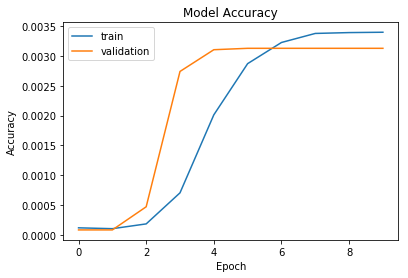

In [44]:
def fit_save_skipgram_clothing_model(weights_file, json_file):
    batch_size = 1024
    nb_train_samples = 350000
    nb_val_samples = 86000
    epochs = 10
    model = make_skipgrams_clothing_model()
    train_outfit_permutations_file = 'data-outfits/outfit_permutations_large_train.tsv'
    val_outfit_permutations_file = 'data-outfits/outfit_permutations_large_val.tsv'
    train_generator = make_product_permutation_generator(train_outfit_permutations_file, 
                                                         prods_to_feats, batch_size, prods_to_indexes)
    validation_generator = make_product_permutation_generator(val_outfit_permutations_file, 
                                                         prods_to_feats, batch_size, prods_to_indexes)
    checkpoint = ModelCheckpoint(weights_file, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    history = model.fit_generator(generator=train_generator, 
                                  validation_data=validation_generator,
                                  epochs=epochs, 
                                  steps_per_epoch=nb_train_samples//batch_size,
                                  validation_steps=nb_val_samples//batch_size,
                                  callbacks = [checkpoint])
    print('Saving skipgrams models')
    model.save(weights_file)
    model_json = model.to_json()
    with open(json_file, 'w') as json_file:
        json_file.write(model_json)
    
    print(history.history.keys())
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    return model

skipgram_model_weights_file = 'model_files/outfit_skipgram_model_large_weights.h5'
skipgram_model_json_file = 'model_files/outfit_skipgram_model_large.json'
model_fit_history = fit_save_skipgram_clothing_model(skipgram_model_weights_file, skipgram_model_json_file)

In [45]:
clothing_skipgrams_model = load_model(skipgram_model_weights_file, skipgram_model_json_file)

Loaded model from disk


In [46]:
# Predicted Output
test_prod_feat = prods_to_feats['491567654']
clothing_skipgrams_model.predict(np.array([test_prod_feat]))

array([[[  6.88066939e-05,   6.88129003e-05,   7.58601163e-05, ...,
           5.46067713e-05,   7.17010989e-05,   9.71829504e-05]]], dtype=float32)

In [47]:
def display_product_images(product_ids):
    image_count = len(product_ids)
    fig, ax = plt.subplots(1, image_count, figsize=(image_count*5, 4))
    
    for i, product_id in enumerate(product_ids):
        image_file = 'data-outfits/images_large/' + product_id + '.jpg'
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
        ax[i].imshow(image, interpolation='nearest')
        ax[i].axis("off")
    plt.show()
    

print('Making Nearest Neighbors ...')
#neighbors_model = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute')
neighbors_model = NearestNeighbors(n_neighbors=20, metric='l2', algorithm='auto')
neighbors_model.fit(prod_features)

Making Nearest Neighbors ...


NearestNeighbors(algorithm='auto', leaf_size=30, metric='l2',
         metric_params=None, n_jobs=1, n_neighbors=20, p=2, radius=1.0)

In [35]:
def get_closest_product_ids(input_features, model, index_to_prod_mapping):
    product_indexes = model.kneighbors(input_features, 15, return_distance=False)
    return [index_to_prod_mapping[index] for index in product_indexes[0]]

Input & Output Products: ['656030581', '637612544', '380490225', '636824829']


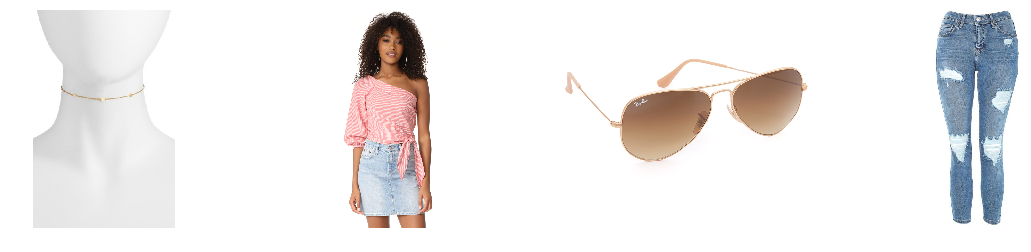

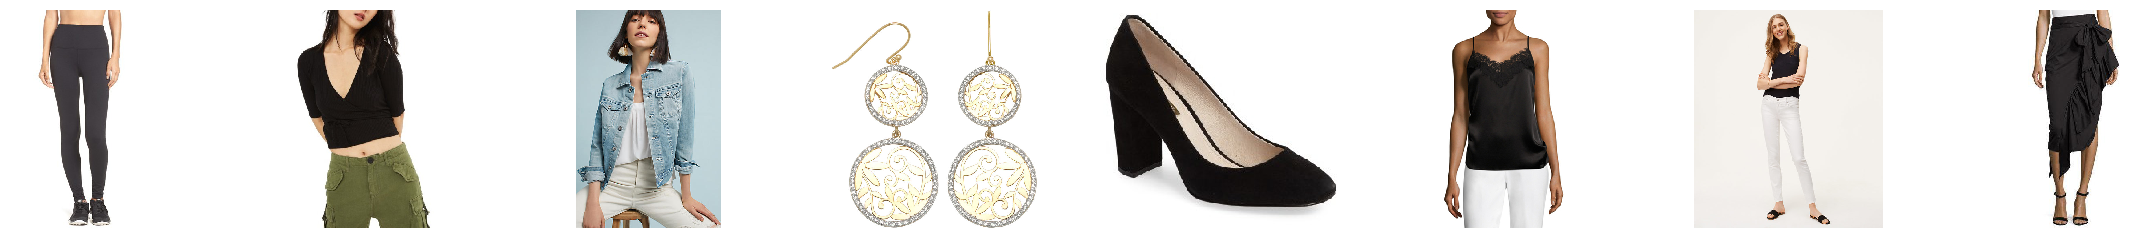

Input & Output Products: ['453380898', '369010583', '626886241', '643340277']


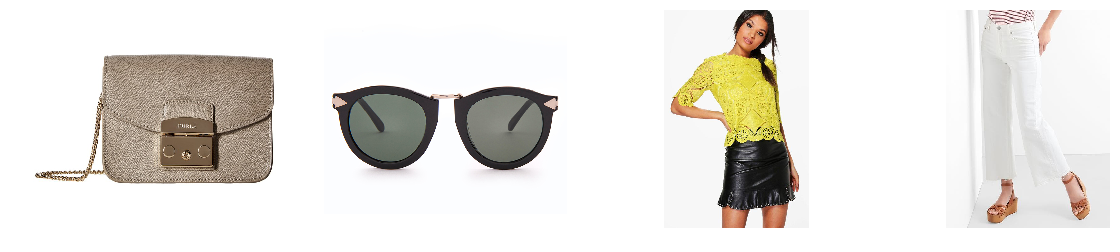

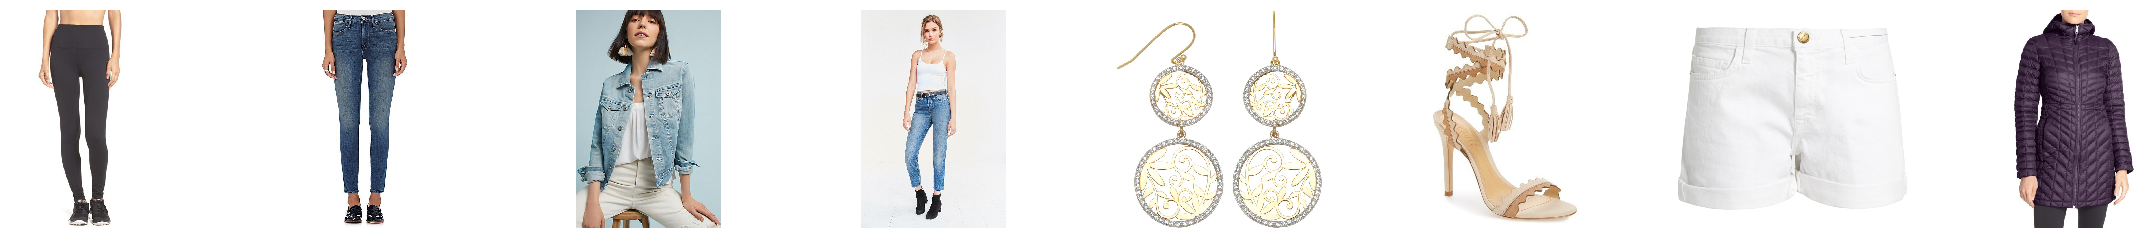

Input & Output Products: ['627508245', '645266283', '470094460', '500071272']


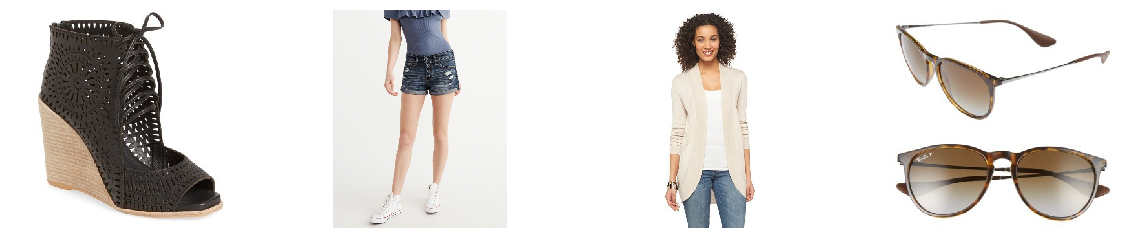

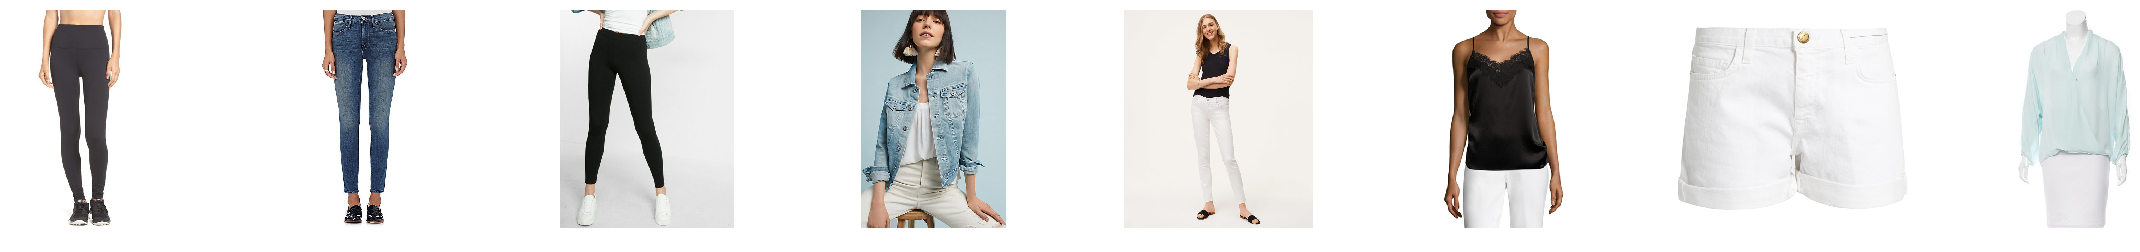

Input & Output Products: ['531074106', '532359614', '664385862', '617669606']


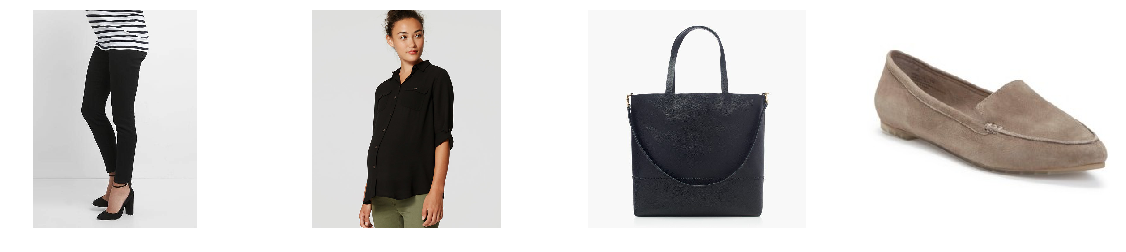

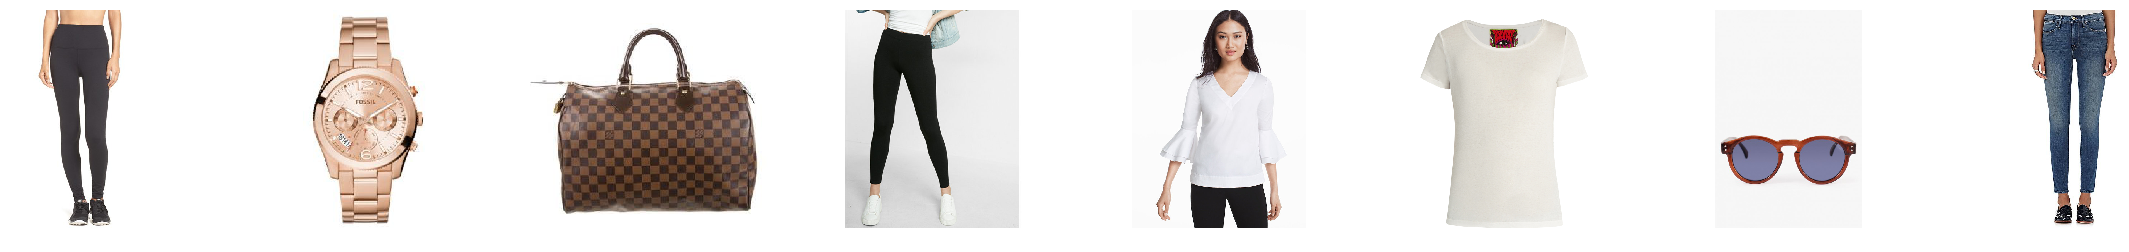

Input & Output Products: ['461207921', '532120670', '654928007', '657514201']


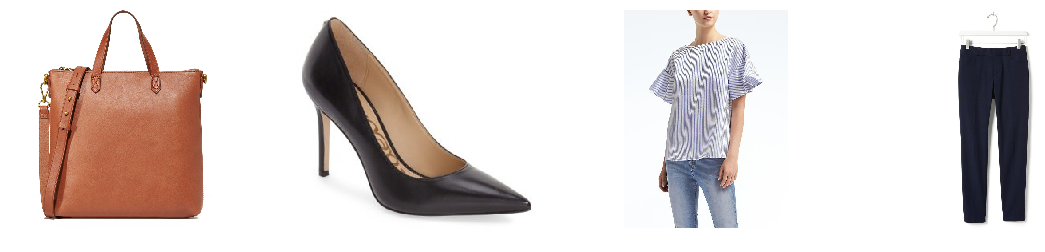

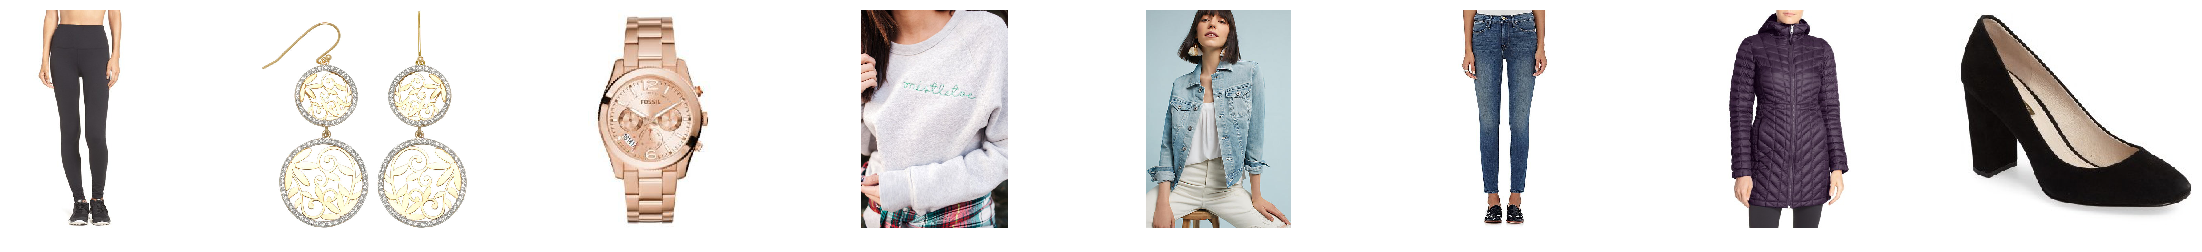

Input & Output Products: ['477075473', '633921026', '622038525', '637781452']


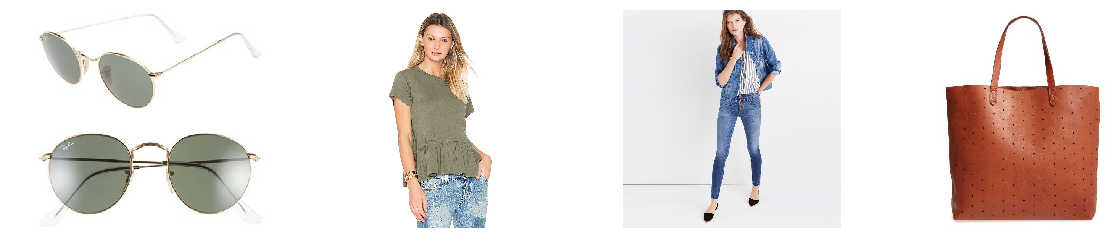

KeyboardInterrupt: 

In [42]:
def test_predictions():
    test_file = 'data-outfits/outfit_permutations_large_sample.tsv'
    with open(test_file, 'r') as f:
        for i, line in enumerate(f.readlines()[:25]):
            l = line.split()
            product1_id = l[2]
            product2_id = l[5]
            product3_id = l[8]
            product4_id = l[11]
            product_ids = [product1_id, product2_id, product3_id, product4_id]
                        
            print('Input & Output Products: {}'.format(product_ids))
            display_product_images(product_ids)
            input_feats = prods_to_feats[product1_id]
            
            prediction_probs = clothing_skipgrams_model.predict(np.array([input_feats]))[0]
            prediction_probs = prediction_probs[0]
            top_product_indexes = prediction_probs.argsort()[-8:][::-1]
            top_product_ids = [indexes_to_prods[i] for i in top_product_indexes]

            display_product_images(top_product_ids)
            
test_predictions()

In [ ]:
a = np.array([[1,2, 3]])
b = np.array([[4,5, 6]])
ab = np.concatenate((a, b, a), axis=1)

In [36]:
arr = np.array([1, 3, 2, 4, 5])
arr.argsort()[-3:][::-1]

array([4, 3, 1])

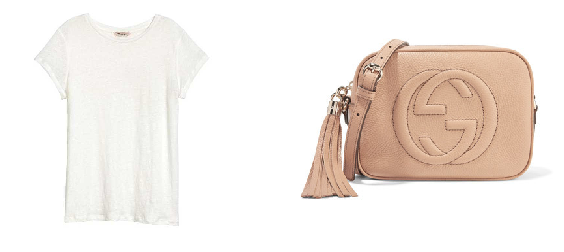

In [24]:
white_shirt_id = '633073622'
pink_bag_id = '645667402'
display_product_images([white_shirt_id, pink_bag_id])

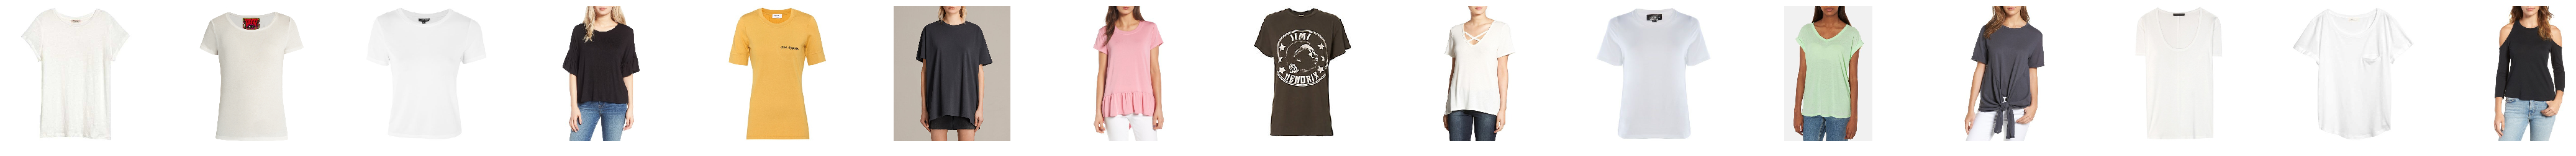

In [39]:
white_shirt_vector = prods_to_feats[white_shirt_id]
closest_white_shirt_ids = get_closest_product_ids(white_shirt_vector, neighbors_model, index_to_prod)
display_product_images(closest_white_shirt_ids)

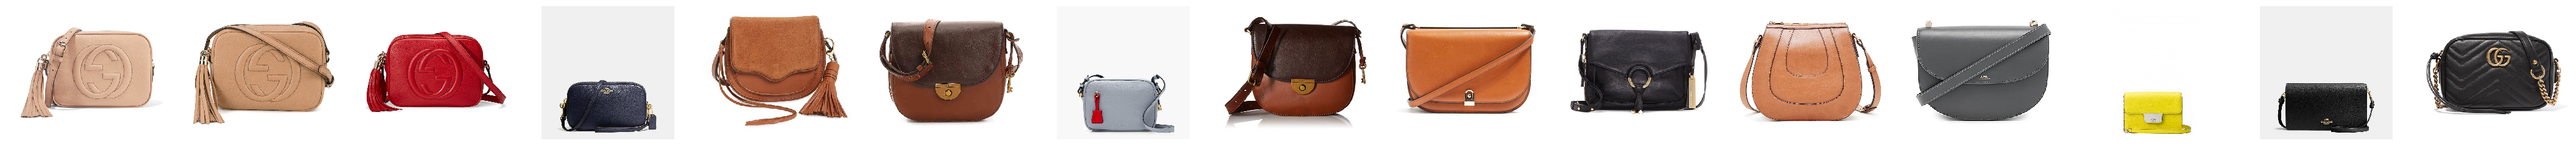

In [40]:
pink_bag_vector = prods_to_feats[pink_bag_id]
closest_pink_bag_ids = get_closest_product_ids(pink_bag_vector, neighbors_model, index_to_prod)
display_product_images(closest_pink_bag_ids)

In [18]:
tester = np.zeros(10)
tester[1] = 1
tester

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])